# LayerNorm Exploration

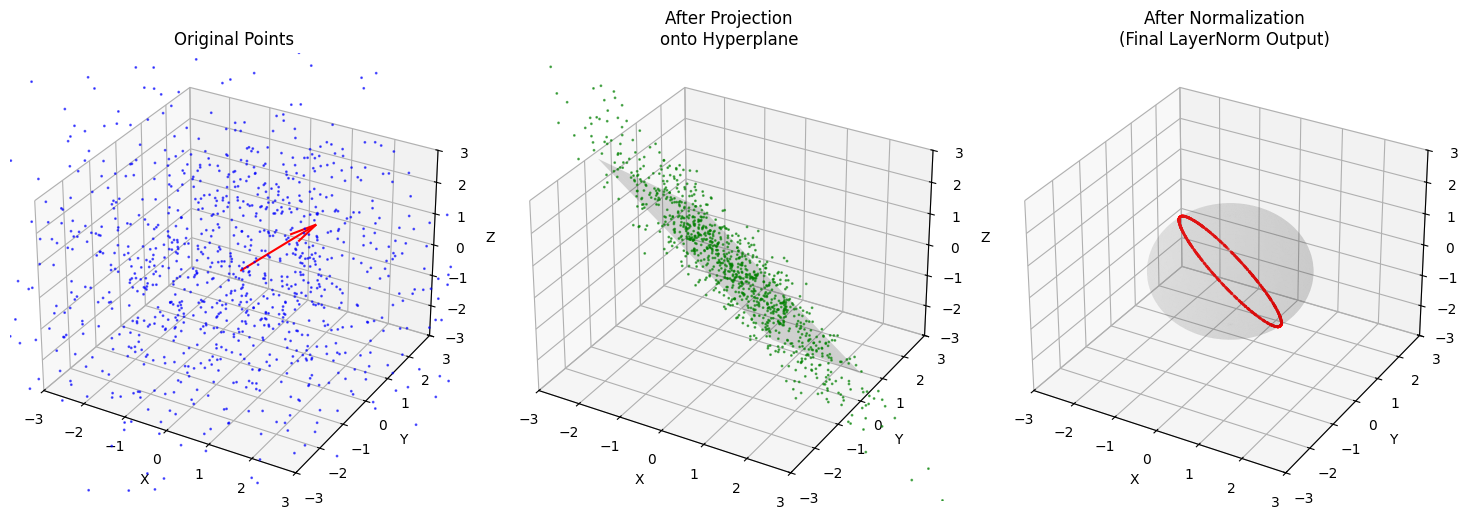

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class LayerNorm(nn.Module):
    eps: float = 1e-5
    
    @nn.compact
    def __call__(self, x):
        # Step 1: Project onto hyperplane (center)
        mean = jnp.mean(x, axis=-1, keepdims=True)
        x_centered = x - mean
        
        # Step 2: Scale to lie within N-ball
        var = jnp.var(x, axis=-1, keepdims=True, ddof=0)
        x_normalized = x_centered / jnp.sqrt(var + self.eps)
        
        return x_normalized, x_centered

def visualize_layernorm_steps():
    # Set random seed for reproducibility
    key = jax.random.PRNGKey(0)
    
    # Generate random 3D points
    n_points = 1000
    points = jax.random.normal(key, (n_points, 3)) * 2

    # Initialize LayerNorm
    layer_norm = LayerNorm()
    variables = layer_norm.init(key, points)
    
    # Pass the points through the LayerNorm module
    points_normalized, points_centered = layer_norm.apply(variables, points)
    
    # Convert to numpy for plotting
    points = np.array(points)
    points_centered = np.array(points_centered)
    points_normalized = np.array(points_normalized)
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Original points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', alpha=0.6, s=1)
    ax1.set_title('Original Points')
    
    # Add unit vector in direction [1,1,1] to show projection axis
    origin = np.zeros(3)
    ones_vector = np.ones(3) / np.sqrt(3)
    ax1.quiver(origin[0], origin[1], origin[2],
               ones_vector[0], ones_vector[1], ones_vector[2],
               color='r', length=2, label='[1,1,1] direction')
    
    # Plot 2: After centering (projection onto hyperplane)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(points_centered[:, 0], points_centered[:, 1], 
                points_centered[:, 2], c='g', alpha=0.6, s=1)
    ax2.set_title('After Projection\nonto Hyperplane')
    
    # Plot plane perpendicular to [1,1,1]
    xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    a, b, c = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)  # Normal vector components
    d = 0  # Distance from origin
    zz = -(a*xx + b*yy - d)/c
    ax2.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    # Plot 3: After normalization
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(points_normalized[:, 0], points_normalized[:, 1],
                points_normalized[:, 2], c='r', alpha=0.6, s=1)
    ax3.set_title('After Normalization\n(Final LayerNorm Output)')
    
    # Add sphere to show the normalization constraint
    r = np.sqrt(3)  # radius = sqrt(N) as per paper
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax3.plot_surface(x, y, z, color='gray', alpha=0.1)
    
    # Set same scale for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([-3, 3])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

# Create and show the visualization
fig = visualize_layernorm_steps()
plt.show()